# Code for Task 4 - Callaway growth model

### Author: Giovanni Zago

In [2]:
library(igraph)
library(magrittr)
set.seed(9112001)

### Simulation of the growth model

In [3]:
N_iter = 10000
N_rep = 5

de_seq = seq(from = 0, to = 1, length.out = N_probs)
gcomp_sizes = rep(0, N_probs)
gcomp_sizes_handler = rep(0, N_rep)

In [4]:
for (i in seq_along(de_seq)) {
    for (j in 1:N_rep) {
        g = make_empty_graph(directed = FALSE)
        g = add_vertices(g, 1)

        for (t in 2:N_iter) {
            g = add_vertices(g, 1)
            samp = runif(1)

            if (samp <= de_seq[i]) {
                verts = sample(1:vcount(g), 2)
                g = add_edges(g, verts)
            }   
        }

        gcomp_sizes_handler[j] = vcount(largest_component(g)) / vcount(g)
    }
    gcomp_sizes[i] = mean(gcomp_sizes_handler)
    gcomp_sizes_handler = rep(0, N_rep)
}

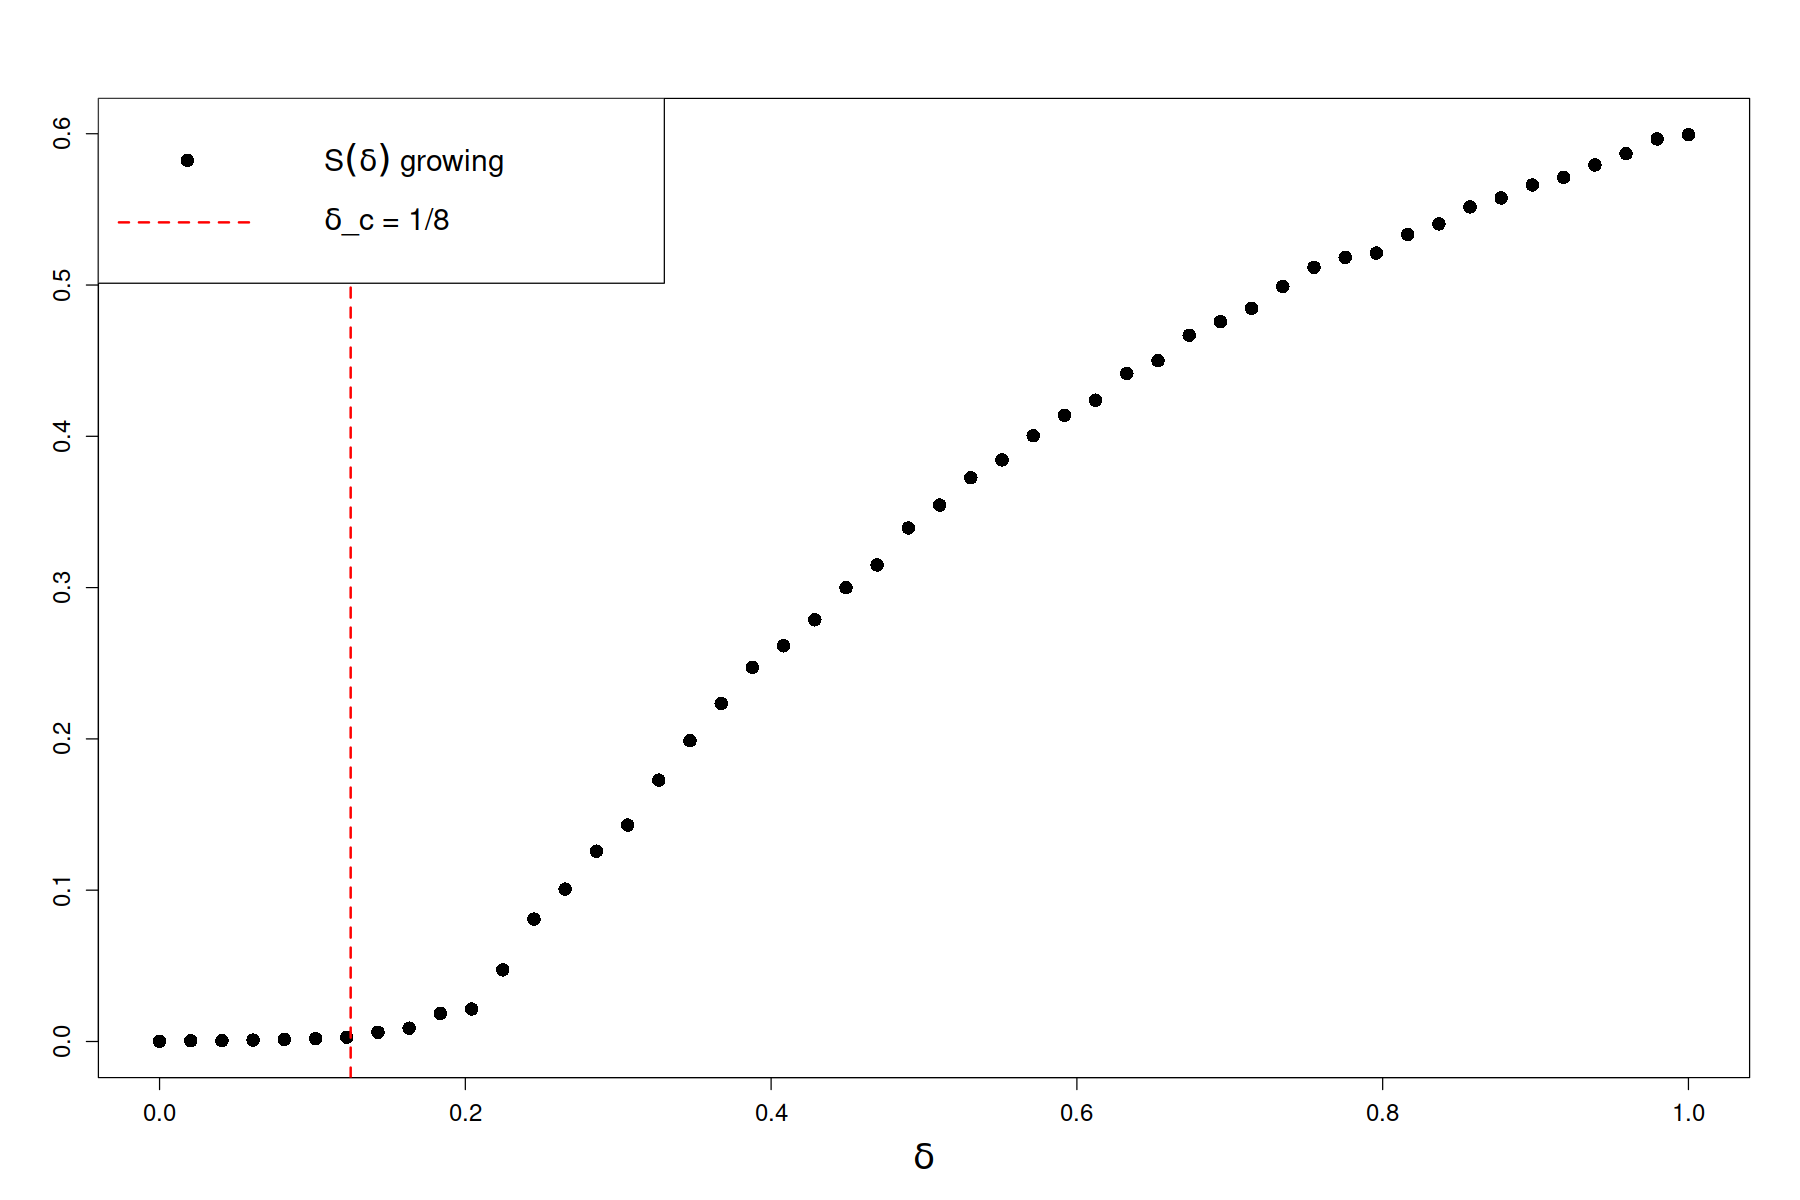

In [93]:
options(repr.plot.width = 15, repr.plot.height = 10)
plot(de_seq, gcomp_sizes, pch = 16, cex = 1.5, 
    xlab = expression(delta), ylab = '',
    cex.axis = 1.2, cex.main = 2, cex.lab = 1.8)
abline(v = 1/8, lty = 8, lwd = 2, col = 'red')
legend('topleft', legend = c(expression(paste(S(delta), ' growing')), expression(paste(delta, '_c = 1/8'))), 
    pch = c(16, NA), lty = c(NA, 8), col = c('black', 'red'), lwd = c(NA, 2),
    text.width = 0.2, cex = 1.5)

### Comparison with the Molloy-Reed static graph

In [6]:
N_mr = 10000
g_mr_comp_sizes = rep(0, N_probs)

for (i in seq_along(de_seq)) {
    degs = sample(0:100, N_mr, replace=TRUE, prob = (2 * de_seq[i]) ** (0:100) / (1 + 2 * de_seq[i]) ** ((0:100) + 1))

    # Note, that we correct the degree sequence if its sum is odd
    if (sum(degs) %% 2 != 0) { degs[1] = degs[1] + 1 }

    g_mr = sample_degseq(degs, method="simple.no.multiple") 
    g_mr_comp_sizes[i] = vcount(largest_component(g_mr)) / vcount(g_mr)
}

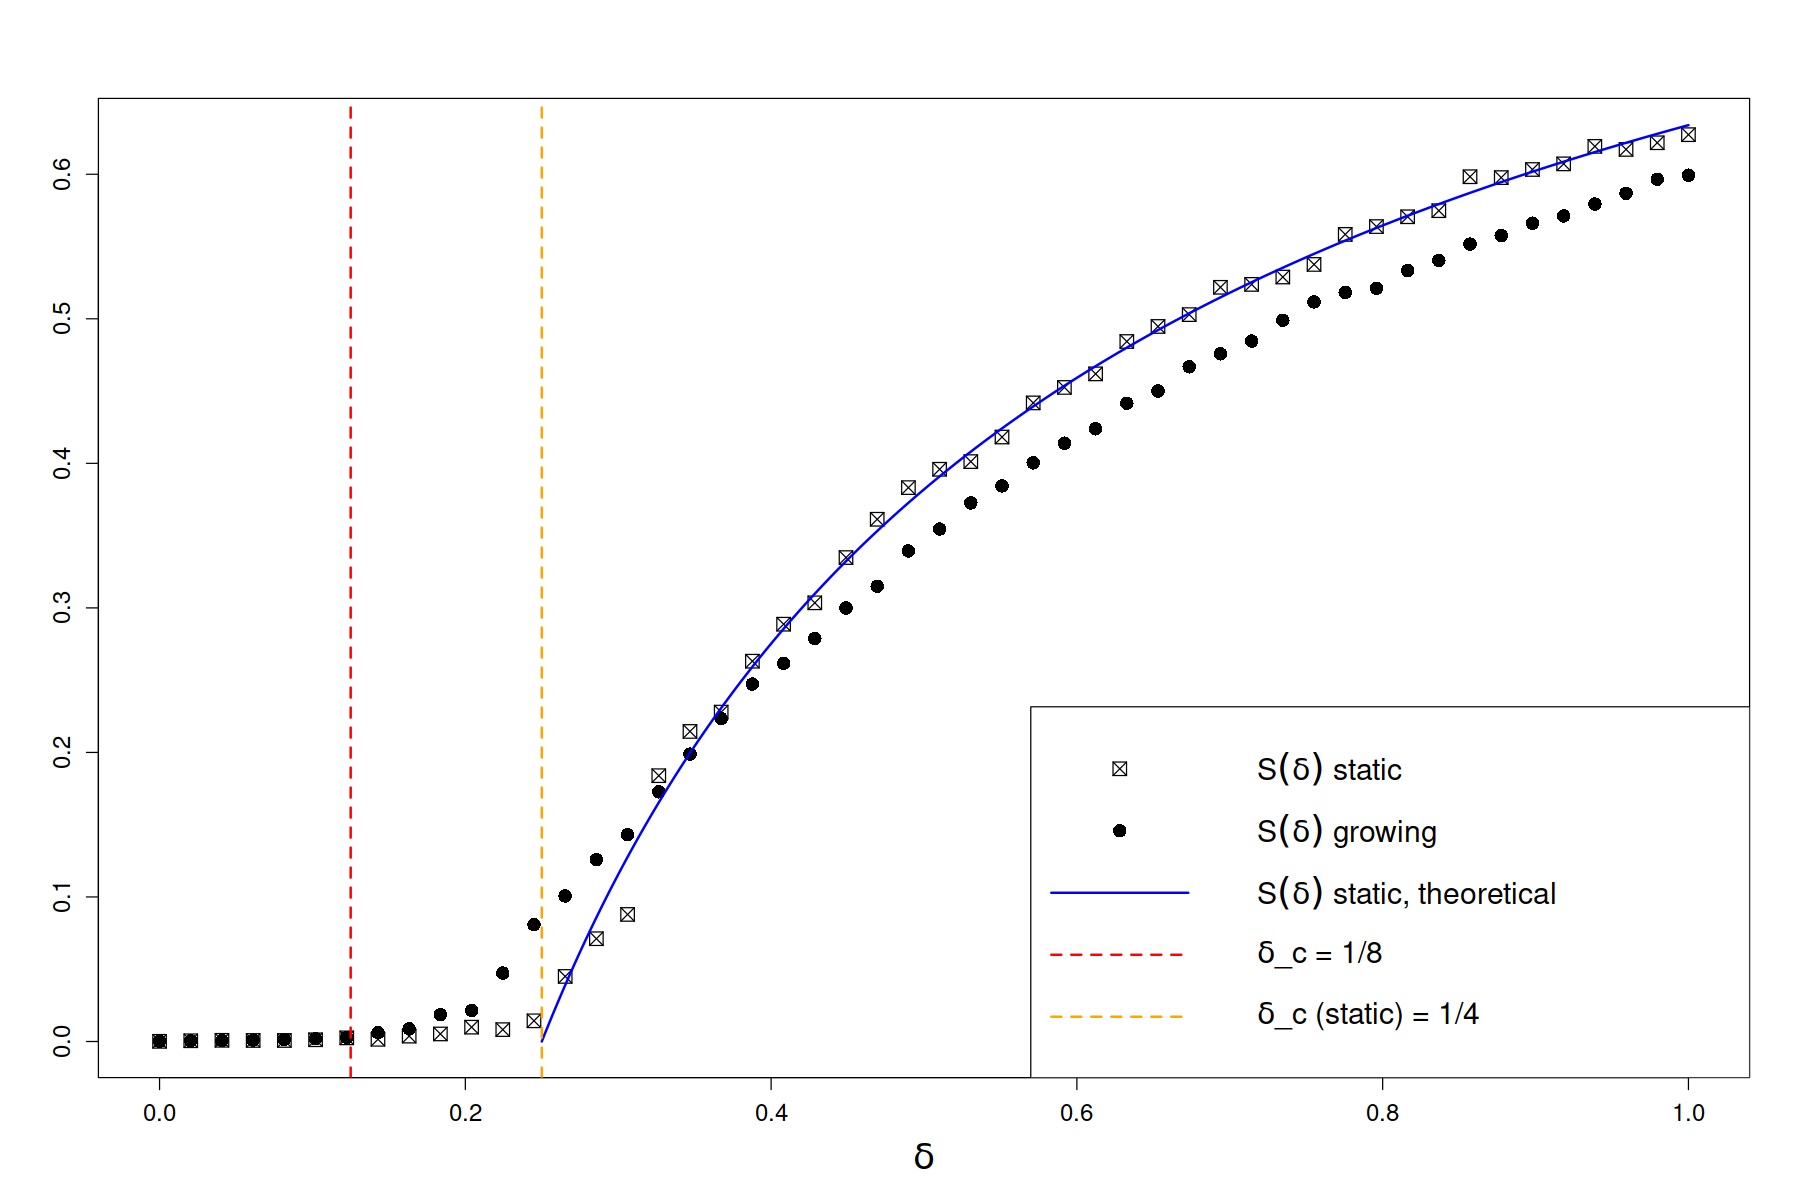

In [96]:
plot(de_seq, g_mr_comp_sizes, pch = 7, cex = 1.5, 
    xlab = expression(delta), ylab = '',
    cex.axis = 1.2, cex.main = 2, cex.lab = 1.8)
points(de_seq, gcomp_sizes, pch = 16, cex = 1.5)
x = seq(from = 0.25, to = 1, length.out = 500)
lines(x, 1 - 1 / (x + sqrt(x ** 2 + 2 * x)), col = 'blue', lwd = 2)
abline(v = 1/8, lty = 8, lwd = 2, col = 'red')
abline(v = 1/4, lty = 8, lwd = 2, col = 'orange')
legend('bottomright', text.width = 0.3,
    legend = c(expression(paste(S(delta), ' static')), 
        expression(paste(S(delta), ' growing')), 
        expression(paste(S(delta), ' static, theoretical')), 
        expression(paste(delta, '_c = 1/8')), 
        expression(paste(delta, '_c (static) = 1/4'))), 
    pch = c(7, 16, NA, NA, NA), lty = c(NA, NA, 1, 8, 8), 
    lwd = c(NA, NA, 2, 2, 2), col = c('black', 'black', 'blue', 'red', 'orange'),
    cex = 1.5)

### Investigating the order of the phase transition

In [9]:
N_iter2 = 10000
delta_de_seq = 10 ** (seq(-4, 0, length.out = N_probs))
de_c = 1 / 8
gcomp_sizes2 = rep(0, N_probs)
gcomp_sizes2_handler = rep(0, N_rep)

for (i in seq_along(delta_de_seq)) {
    for (j in 1:N_rep) {
        g = make_empty_graph(directed = FALSE)
        g = add_vertices(g, 1)

        for (t in 2:N_iter2) {
            g = add_vertices(g, 1)
            samp = runif(1)

            if (samp <= (delta_de_seq[i]) + de_c) {
                verts = sample(1:vcount(g), 2)
                g = add_edges(g, verts)
            }   
        }

        gcomp_sizes2_handler[j] = vcount(largest_component(g)) / vcount(g)
    }
    gcomp_sizes2[i] = mean(gcomp_sizes2_handler)
    gcomp_sizes2_handler = rep(0, N_rep)
}

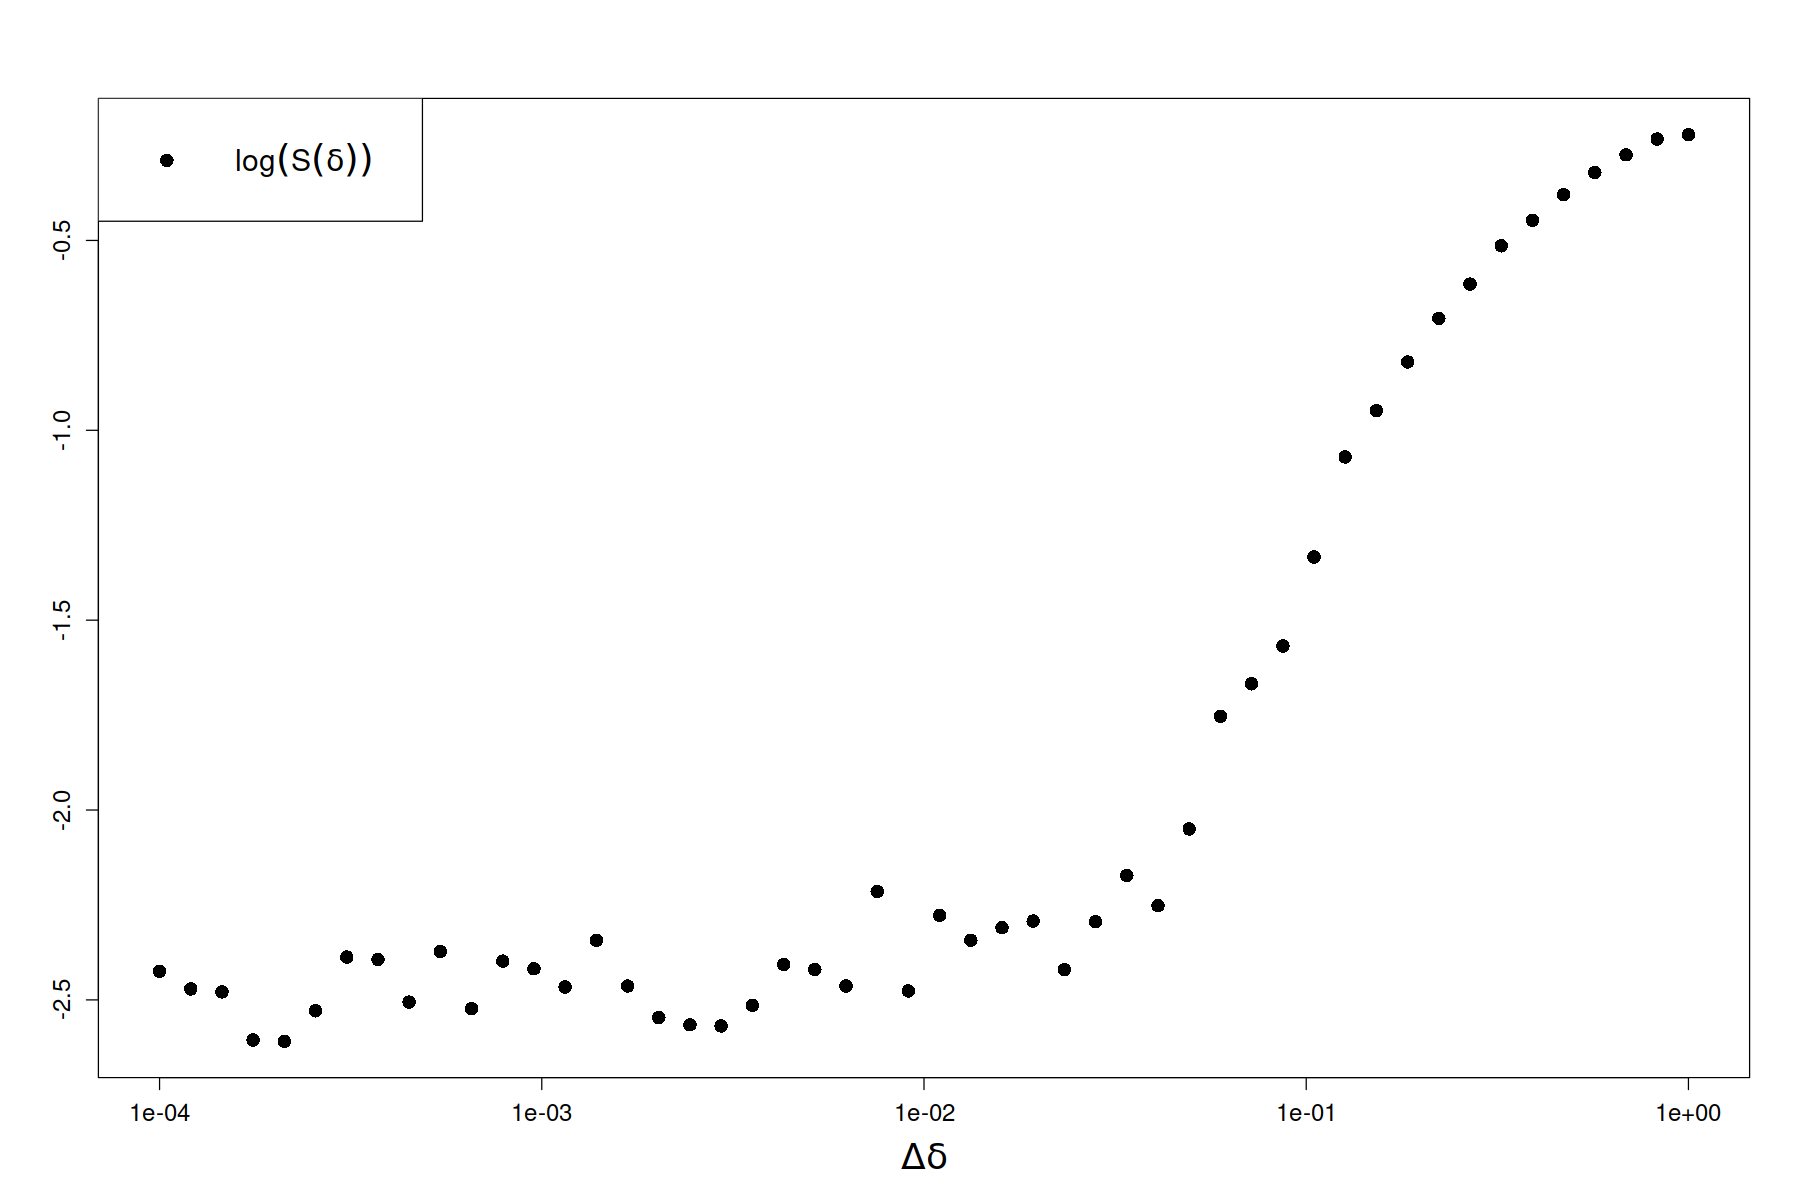

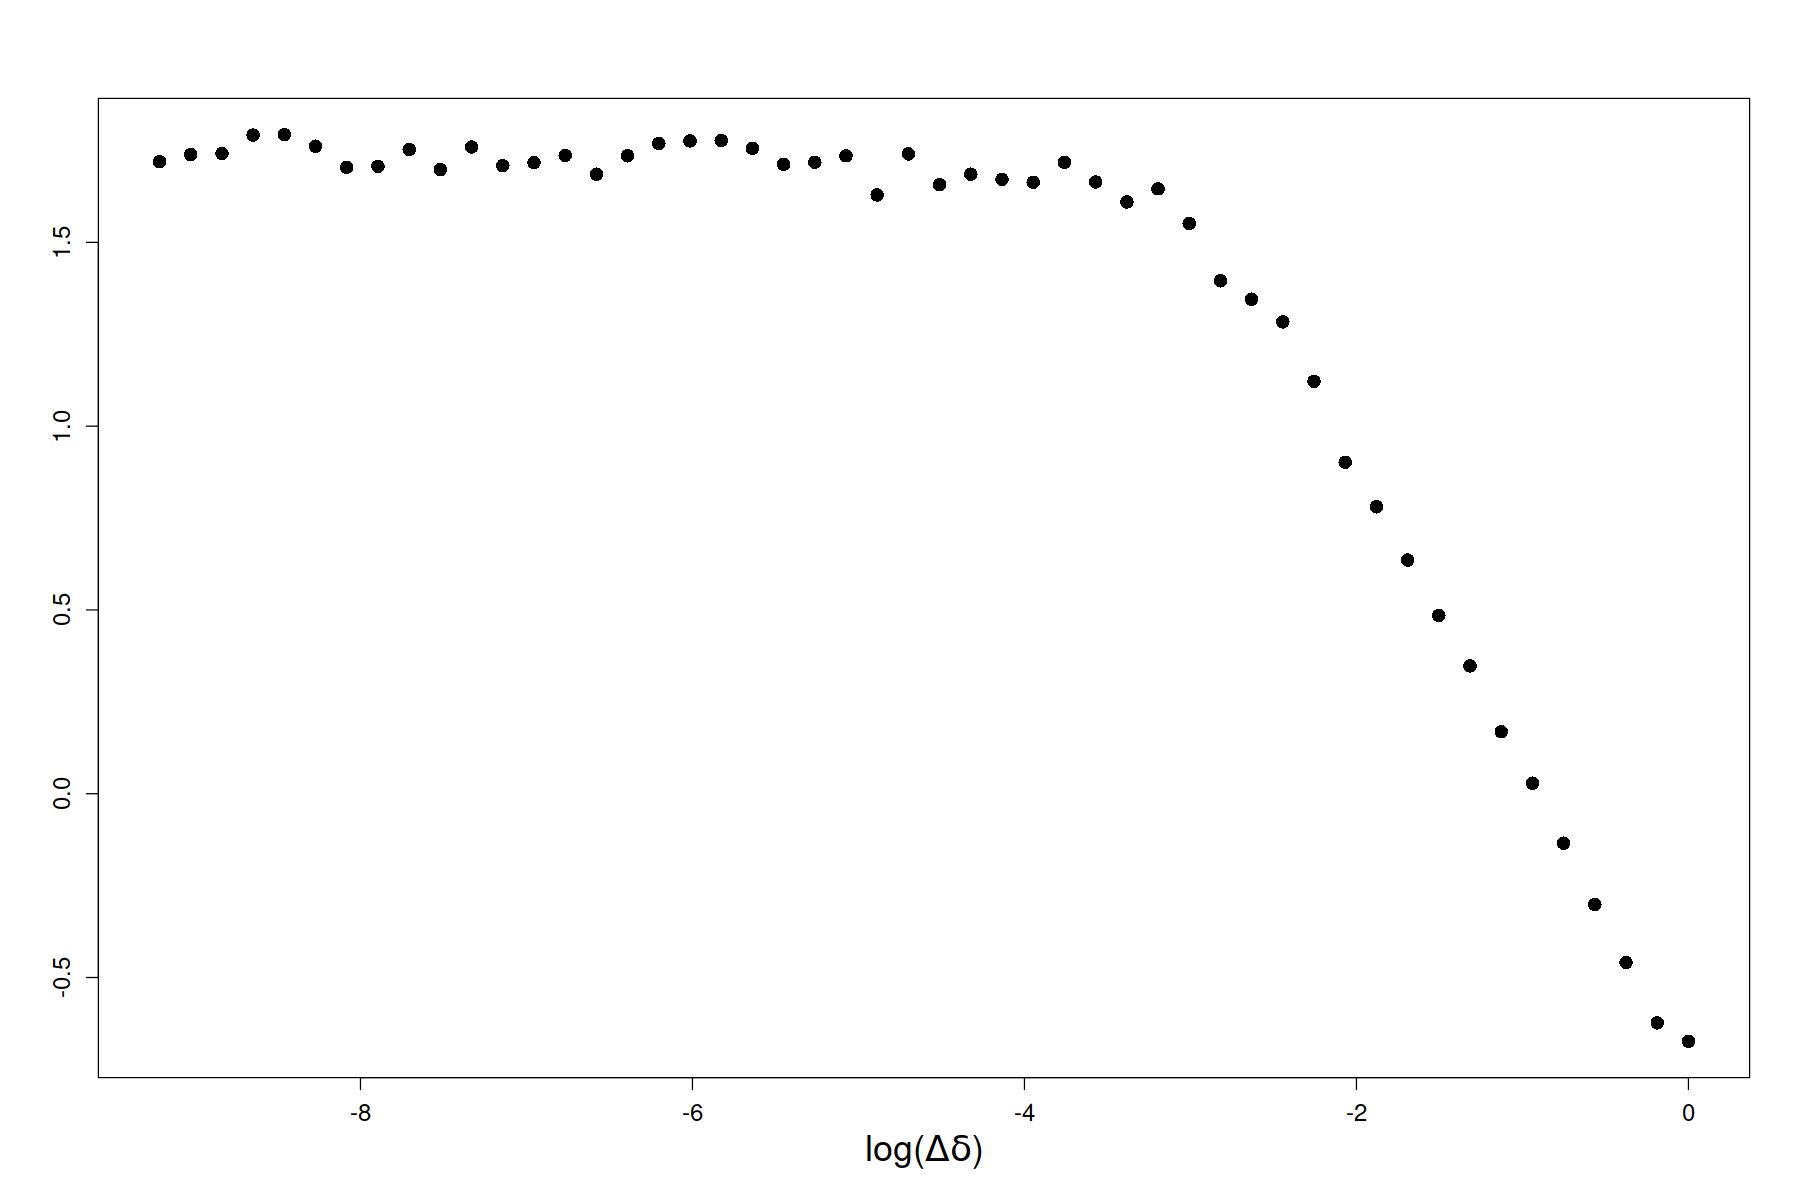

In [62]:
plot(delta_de_seq, log10(gcomp_sizes2), pch = 16, log = 'x', 
    cex = 1.5, 
    xlab = expression(paste(Delta, delta)), ylab = '',
    cex.axis = 1.2, cex.lab = 1.8)
legend('topleft', text.width = 0.4,
    legend = c(expression(paste('log', (S(delta))))), 
    pch = c(16), cex = 1.5)
plot(log(delta_de_seq), log(-log(gcomp_sizes2)), pch = 16, 
    cex = 1.5, 
    xlab = expression(paste('log(', Delta, delta, ')')), ylab = '',
    cex.axis = 1.2, cex.lab = 1.8)

Setup and perform linear regression in order to estimate critical parameters

In [11]:
x = log(delta_de_seq)
y = log(-log(gcomp_sizes2))
x = x[which(x <= -4)]
y = y[which(x <= -4)]
fit_data = data.frame(x = x, y = y)
head(fit_data)

,x,y
,<dbl>,<dbl>
1,-9.210340,1.719787
2,-9.022374,1.738689
3,-8.834408,1.741832
4,-8.646442,1.791676
5,-8.458476,1.793024
6,-8.270510,1.761741



Call:
lm(formula = y ~ x, data = fit_data)

Residuals:
      Min        1Q    Median        3Q       Max 
-0.078482 -0.029639  0.002158  0.028207  0.059158 

Coefficients:
             Estimate Std. Error t value Pr(>|t|)    
(Intercept)  1.652335   0.031301  52.789   <2e-16 ***
x           -0.011312   0.004574  -2.473   0.0202 *  
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 0.03675 on 26 degrees of freedom
Multiple R-squared:  0.1904,	Adjusted R-squared:  0.1593 
F-statistic: 6.117 on 1 and 26 DF,  p-value: 0.02025


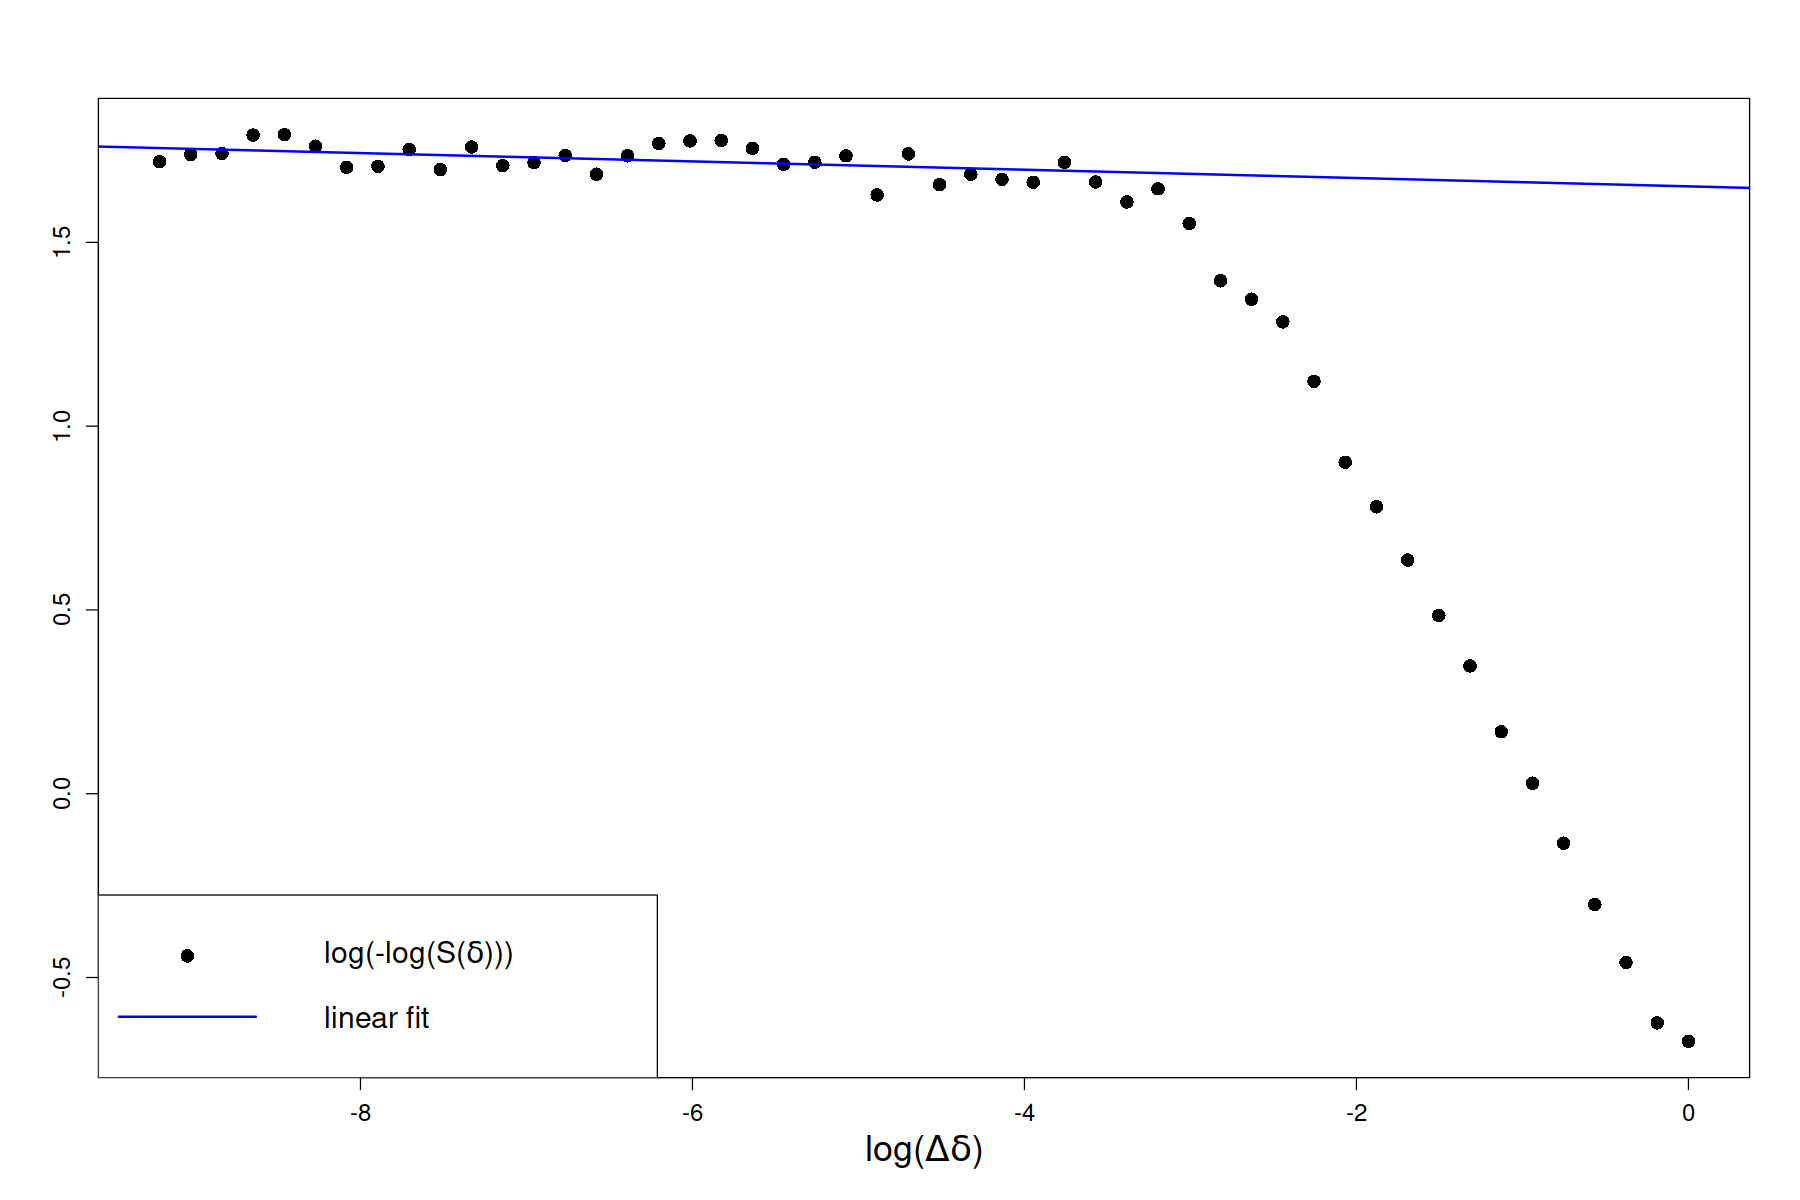

In [74]:
model = lm(formula = y ~ x, data = fit_data)
summary(model)
plot(log(delta_de_seq), log(-log(gcomp_sizes2)), pch = 16, 
    cex = 1.5, 
    xlab = expression(paste('log(', Delta, delta, ')')), ylab = '',
    cex.axis = 1.2, cex.lab = 1.8)
abline(model, col = 'blue', lwd = 2)
legend('bottomleft', text.width = 1.8,
    legend = c(expression(paste('log(-log(S(', delta, ')))')), 'linear fit'), 
    pch = c(16, NA), lty = c(NA, 1), lwd = c(NA, 2), col = c('black', 'blue'),
    cex = 1.5)

### Investigating the degree correlation in Callaway growing networks

In [13]:
e_deg_count = function(g, k, l) {
    m = as_adjacency_matrix(g, "both")
    m = m[degree(g) == k, degree(g) == l]
    return(sum(m))
}

In [14]:
rho_connv = rep(0, N_probs)
rho_connv_handler = rep(0, N_rep)

for (i in seq_along(de_seq)) {
    for (j in 1:N_rep) {
        g = make_empty_graph(directed = FALSE)
        g = add_vertices(g, 1)

        for (t in 2:N_iter) {
            g = add_vertices(g, 1)
            samp = runif(1)

            if (samp <= de_seq[i]) {
                verts = sample(1:vcount(g), 2)
                g = add_edges(g, verts)
            }   
        }

        k_max = max(degree(g))
        l_max = max(degree(g))

        sum = 0

        if (i == 1) {
            rho_connv[i] = 0
        } else {
            for (k in 1:k_max) {
                for (l in 1:l_max) {
                    foo = (e_deg_count(g, k, l) / (2 * de_seq[i] * N_iter))
                    sum = sum + (k - (1 + 4 * de_seq[i])) * (l - (1 + 4 * de_seq[i])) * foo
                }
            }

            rho_connv_handler[j] = sum / (4 * de_seq[i] * (1 + 2 * de_seq[i]))
        }
    }

    rho_connv[i] = mean(rho_connv_handler)
}

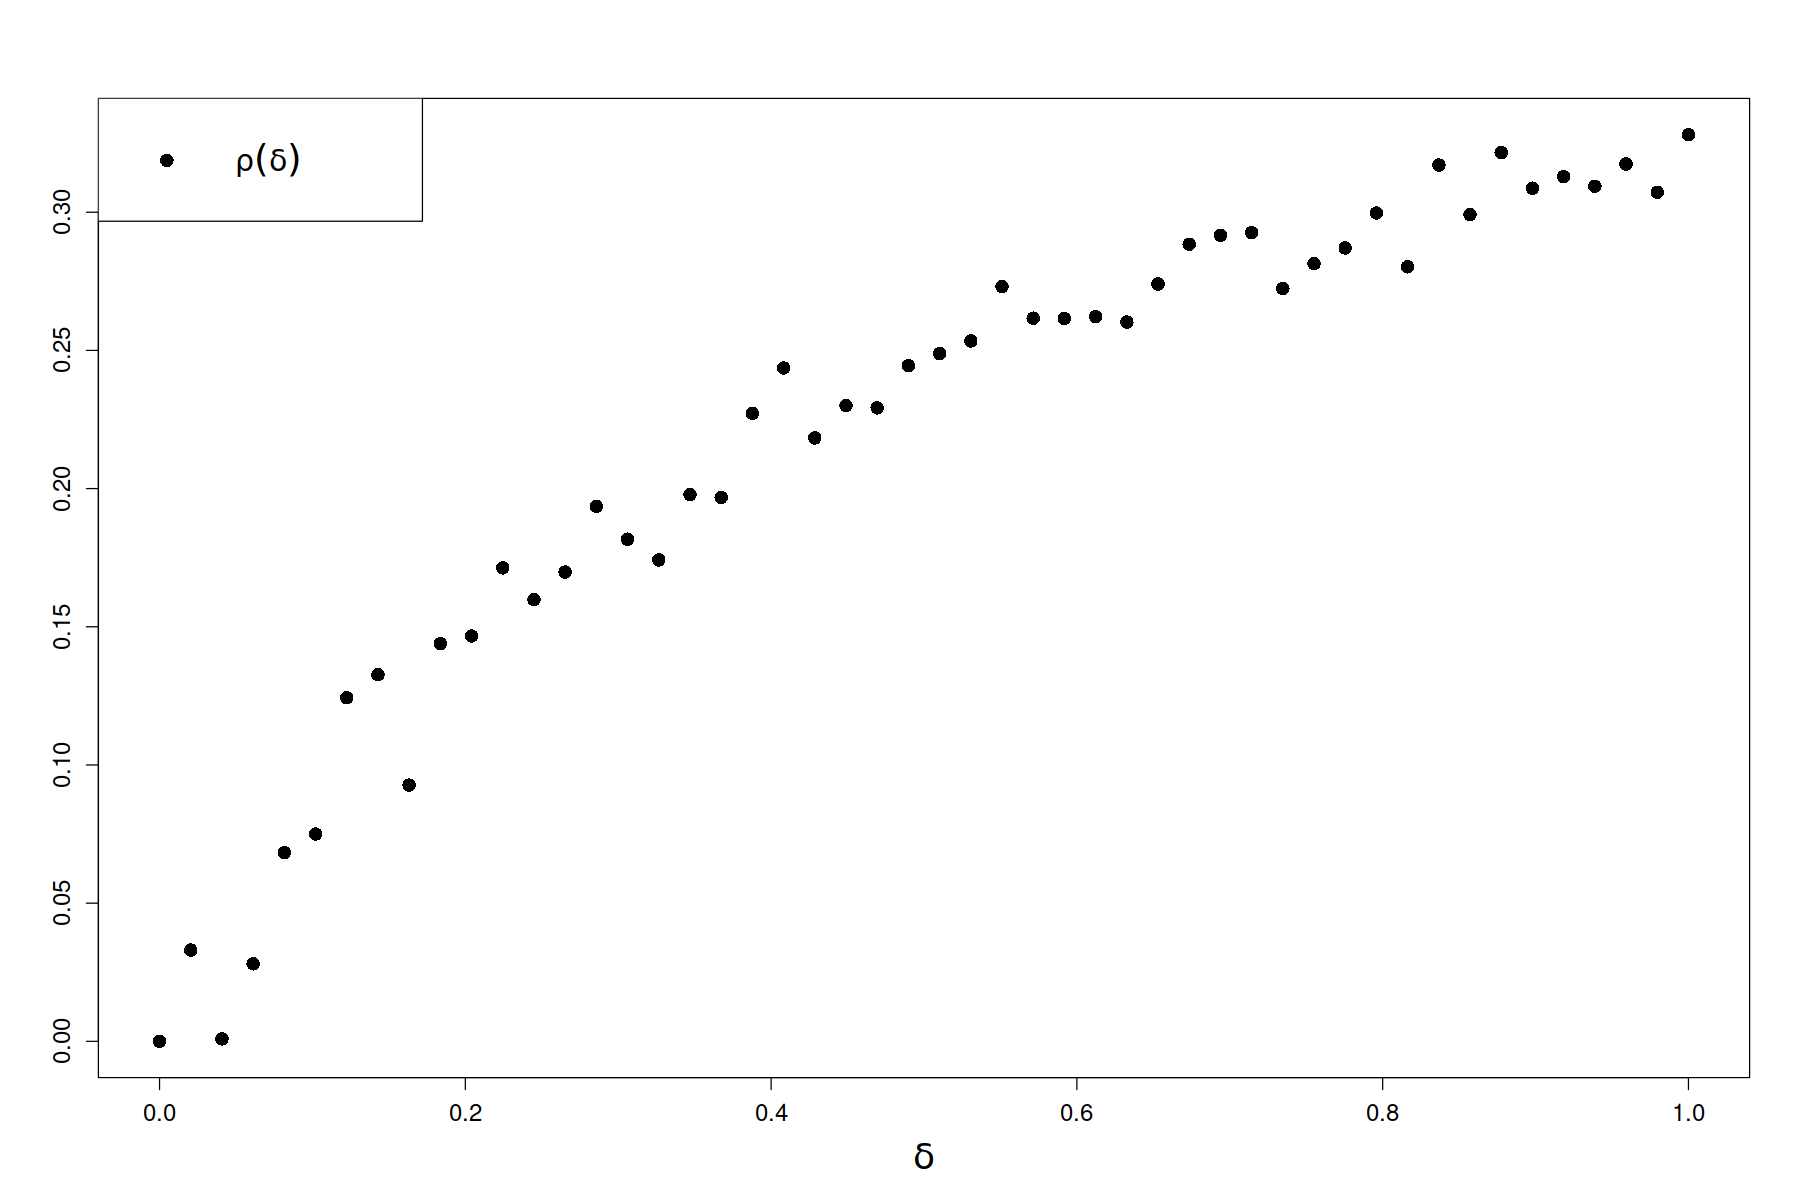

In [77]:
plot(de_seq, rho_connv, 
    pch = 16, cex = 1.5, 
    xlab = expression(delta), ylab = '',
    cex.axis = 1.2, cex.lab = 1.8)
legend('topleft', legend = c(expression(rho(delta))), pch = 16, text.width = 0.1, cex = 1.5)